<a href="https://colab.research.google.com/github/RahulSinghWaldia/TED-TALK-VIEWS-PREDICTION/blob/main/TED_TALK_VIEWS_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I will be using ensebmle regression methods to predict the views given talk will accumulate.

In [ ]:
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

from xgboost import XGBRegressor, plot_importance

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")



In [ ]:
df = pd.read_csv(r'/content/sample_data/ted_main.csv')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2550 non-null   int64 
 1   description         2550 non-null   object
 2   duration            2550 non-null   int64 
 3   event               2550 non-null   object
 4   film_date           2550 non-null   int64 
 5   languages           2550 non-null   int64 
 6   main_speaker        2550 non-null   object
 7   name                2550 non-null   object
 8   num_speaker         2550 non-null   int64 
 9   published_date      2550 non-null   int64 
 10  ratings             2550 non-null   object
 11  related_talks       2550 non-null   object
 12  speaker_occupation  2544 non-null   object
 13  tags                2550 non-null   object
 14  title               2550 non-null   object
 15  url                 2550 non-null   object
 16  views               2550

Prepare data for modeling - remove missing values, feature engineering, remove outliers

In [ ]:
# There are only 6 rows with missing data for speaker_occupation and I decide to drop those as it will not affect the dataset in a measurable way.
df.dropna(axis=0, subset=['speaker_occupation'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2544 entries, 0 to 2549
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2544 non-null   int64 
 1   description         2544 non-null   object
 2   duration            2544 non-null   int64 
 3   event               2544 non-null   object
 4   film_date           2544 non-null   int64 
 5   languages           2544 non-null   int64 
 6   main_speaker        2544 non-null   object
 7   name                2544 non-null   object
 8   num_speaker         2544 non-null   int64 
 9   published_date      2544 non-null   int64 
 10  ratings             2544 non-null   object
 11  related_talks       2544 non-null   object
 12  speaker_occupation  2544 non-null   object
 13  tags                2544 non-null   object
 14  title               2544 non-null   object
 15  url                 2544 non-null   object
 16  views               2544

Detect and remove outliers from numerical columns

In [ ]:
df.describe()


,comments,duration,film_date,languages,num_speaker,published_date,views
count,2544.000000,2544.000000,2.544000e+03,2544.000000,2544.000000,2.544000e+03,2.544000e+03
mean,191.706761,827.316431,1.321828e+09,27.319969,1.028302,1.343456e+09,1.699779e+06
std,282.613719,373.828955,1.198455e+08,9.563529,0.207945,9.471837e+07,2.501043e+06
min,2.000000,135.000000,7.464960e+07,0.000000,1.000000,1.151367e+09,5.044300e+04
25%,63.000000,578.750000,1.257466e+09,23.000000,1.000000,1.268341e+09,7.565802e+05
50%,118.000000,848.500000,1.333238e+09,28.000000,1.000000,1.340935e+09,1.123870e+06
75%,222.000000,1047.000000,1.412921e+09,33.000000,1.000000,1.423519e+09,1.702149e+06
max,6404.000000,5256.000000,1.503792e+09,72.000000,5.000000,1.506092e+09,4.722711e+07


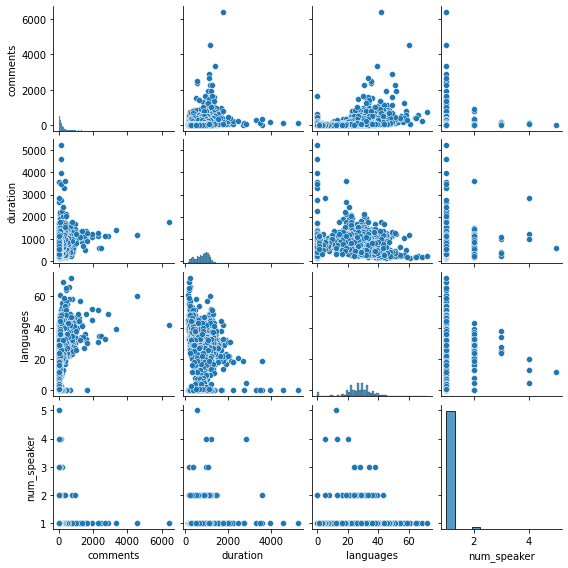

In [ ]:
sns.pairplot(df[['comments', 'duration', 'languages', 'num_speaker']],  size=2)
plt.show()

Standard deviation accross some numerical columns is quite high which suggests that there are outliers.

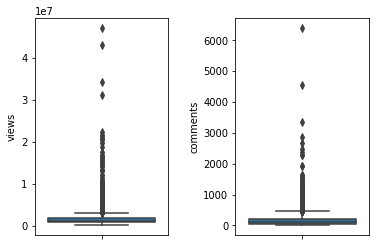

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.boxplot(y= df.views, ax=ax1)
sns.boxplot(y=df.comments, ax=ax2)
plt.subplots_adjust(wspace=0.50)
plt.show()


Indeed the boxplots confirm that those two columns contain many outliers.

In [ ]:
# Compute z-score for each value in a colun relative to the column mean and std and use the resulting value to filter outliers from each specified column in the dataframe.

df = df[(np.abs(stats.zscore(df[['comments', 'views']])) < 3).all(axis=1)]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2485 entries, 1 to 2549
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2485 non-null   int64 
 1   description         2485 non-null   object
 2   duration            2485 non-null   int64 
 3   event               2485 non-null   object
 4   film_date           2485 non-null   int64 
 5   languages           2485 non-null   int64 
 6   main_speaker        2485 non-null   object
 7   name                2485 non-null   object
 8   num_speaker         2485 non-null   int64 
 9   published_date      2485 non-null   int64 
 10  ratings             2485 non-null   object
 11  related_talks       2485 non-null   object
 12  speaker_occupation  2485 non-null   object
 13  tags                2485 non-null   object
 14  title               2485 non-null   object
 15  url                 2485 non-null   object
 16  views               2485

In [ ]:
df.describe()

,comments,duration,film_date,languages,num_speaker,published_date,views
count,2485.000000,2485.000000,2.485000e+03,2485.000000,2485.000000,2.485000e+03,2.485000e+03
mean,165.729980,823.410463,1.322890e+09,27.018109,1.028571,1.344565e+09,1.446370e+06
std,159.211182,374.302186,1.200581e+08,9.356901,0.209450,9.471802e+07,1.222834e+06
min,2.000000,135.000000,7.464960e+07,0.000000,1.000000,1.151367e+09,5.044300e+04
25%,62.000000,576.000000,1.257503e+09,23.000000,1.000000,1.268895e+09,7.452310e+05
50%,114.000000,844.000000,1.334189e+09,28.000000,1.000000,1.342106e+09,1.108528e+06
75%,212.000000,1040.000000,1.413331e+09,32.000000,1.000000,1.424880e+09,1.625469e+06
max,1000.000000,5256.000000,1.503792e+09,72.000000,5.000000,1.506092e+09,9.163813e+06


Now the standard deviation for comments and views columns is lower and mean and max values are not skewed by outliers.

In [ ]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['film_date'] = pd.to_datetime(df['film_date'],unit='s')
df['film_month'] = df['film_date'].apply(lambda x: month_order[int(x.month) - 1])
df['film_day'] = df['film_date'].apply(lambda x: day_order[int(x.day) % 7 - 1])

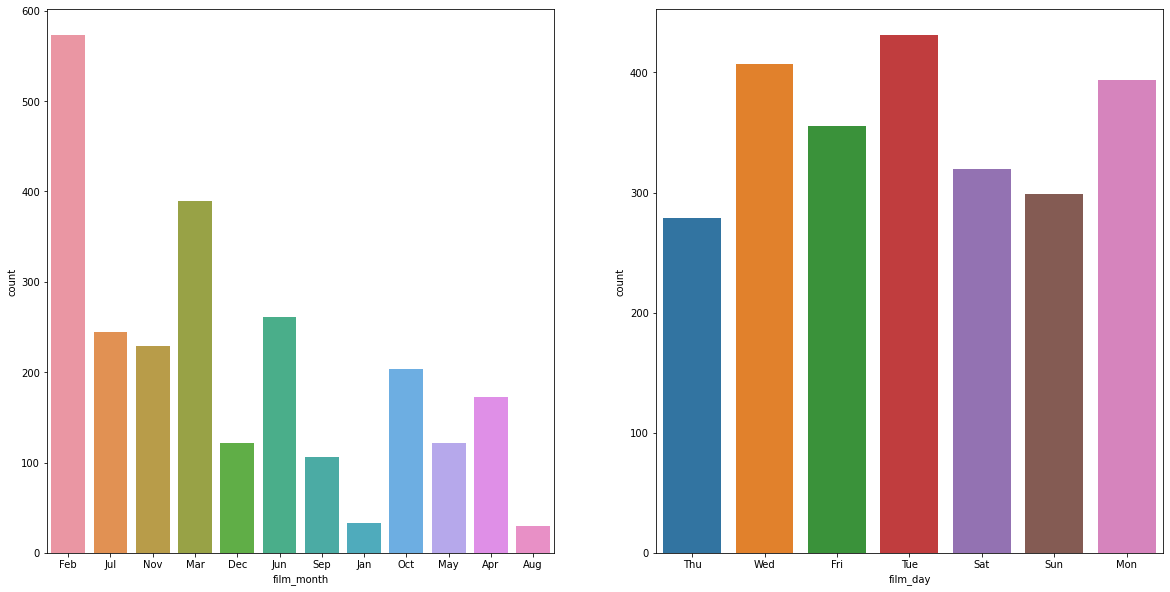

In [ ]:
fig, ax =plt.subplots(1,2, figsize=(20,10))
sns.countplot(df['film_month'], ax=ax[0])
sns.countplot(df['film_day'], ax=ax[1])
fig.show()

Looking at the distribution of talks over week days, we can see that difference is about 25% while the distribution over the months in an year is much more diverese - having less than 100 talks filmmed in January and about 600 in February. Therefore I think that these two new features will have impact on the target feature prediction and I will use them

In [ ]:
def cal_pos_rating_ratio(ratings):
    counter = {'Funny':0, 'Beautiful':0, 'Ingenious':0, 'Courageous':0, 'Longwinded':0, 'Confusing':0, 'Informative':0, 'Fascinating':0, 'Unconvincing':0, 'Persuasive':0, 'Jaw-dropping':0, 'OK':0, 'Obnoxious':0, 'Inspiring':0}
    neg_descriptors = {"Confusing", "Unconvincing", "Longwinded", "Obnoxious", "OK"}
    for rating_list in ratings:
        counter[rating_list['name']] += rating_list['count']
    neg_desc_count = sum([counter[desc] for desc in neg_descriptors])
    total_desc_count = sum(list(counter.values()))
    pos_desc_count = total_desc_count - neg_desc_count
    popular_data_no_tedex_pct_positive = 100 * (pos_desc_count / total_desc_count)
    return popular_data_no_tedex_pct_positive

In [ ]:
df['eval_ratings'] = df['ratings'].apply(lambda x: eval(x))

In [ ]:
df['pos_rating_ratio'] = df.eval_ratings.apply(cal_pos_rating_ratio)

In [ ]:
def rating_count(ratings):
    counter = {'Funny':0, 'Beautiful':0, 'Ingenious':0, 'Courageous':0, 'Longwinded':0, 'Confusing':0, 'Informative':0, 'Fascinating':0, 'Unconvincing':0, 'Persuasive':0, 'Jaw-dropping':0, 'OK':0, 'Obnoxious':0, 'Inspiring':0}
    for rating_list in ratings:
        counter[rating_list['name']] += rating_list['count']
    return  sum(list(counter.values()))

In [ ]:
df['raiting_count'] = df.eval_ratings.apply(rating_count)

In [ ]:
y = df.views
X = df.drop(['views', 'film_date', 'published_date', 'eval_ratings'], axis=1) # drop the columns that are not needed for predictions
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2485 entries, 1 to 2549
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   comments            2485 non-null   int64  
 1   description         2485 non-null   object 
 2   duration            2485 non-null   int64  
 3   event               2485 non-null   object 
 4   languages           2485 non-null   int64  
 5   main_speaker        2485 non-null   object 
 6   name                2485 non-null   object 
 7   num_speaker         2485 non-null   int64  
 8   ratings             2485 non-null   object 
 9   related_talks       2485 non-null   object 
 10  speaker_occupation  2485 non-null   object 
 11  tags                2485 non-null   object 
 12  title               2485 non-null   object 
 13  url                 2485 non-null   object 
 14  film_month          2485 non-null   object 
 15  film_day            2485 non-null   object 
 16  pos_ra

Create train and validation data splits, keep low cardinality columns and one hot encode cathegorical features.

In [ ]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
# Select categorical columns with relatively low cardinality
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 13 and 
                        X_train_full[cname].dtype == "object"] # 13 is used to fit the month encoding

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'uint64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
# One-hot encode the data
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)

In [ ]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1988 entries, 1252 to 1709
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   comments          1988 non-null   int64  
 1   duration          1988 non-null   int64  
 2   languages         1988 non-null   int64  
 3   num_speaker       1988 non-null   int64  
 4   pos_rating_ratio  1988 non-null   float64
 5   raiting_count     1988 non-null   int64  
 6   film_month_Apr    1988 non-null   uint8  
 7   film_month_Aug    1988 non-null   uint8  
 8   film_month_Dec    1988 non-null   uint8  
 9   film_month_Feb    1988 non-null   uint8  
 10  film_month_Jan    1988 non-null   uint8  
 11  film_month_Jul    1988 non-null   uint8  
 12  film_month_Jun    1988 non-null   uint8  
 13  film_month_Mar    1988 non-null   uint8  
 14  film_month_May    1988 non-null   uint8  
 15  film_month_Nov    1988 non-null   uint8  
 16  film_month_Oct    1988 non-null   uint8

Build base model - Decision Tree

1. As a baseline model I will use simple decision tree regressor
2. As a model evaluation metric I will use MAE - mean absolute error


In [ ]:
def get_mae(max_leaf_nodes, X_train, X_valid, y_train, y_valid):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds_val)
    return(mae)


maes_dtr = []
# compare MAE with differing values of max_leaf_nodes
for max_leaf_nodes in [5, 25, 50, 100, 500, 5000]:
    mae_dtr = get_mae(max_leaf_nodes, X_train, X_valid, y_train, y_valid)
    maes_dtr.append(mae_dtr)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, mae_dtr))

Max leaf nodes: 5  		 Mean Absolute Error:  530558
Max leaf nodes: 25  		 Mean Absolute Error:  514890
Max leaf nodes: 50  		 Mean Absolute Error:  522959
Max leaf nodes: 100  		 Mean Absolute Error:  558657
Max leaf nodes: 500  		 Mean Absolute Error:  609034
Max leaf nodes: 5000  		 Mean Absolute Error:  634126


Best performing decision tree model for this task is with 25 leafs.

Build a better model - RandomForest.

In [ ]:
def get_mae(max_leaf_nodes, X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds_val)
    return(mae)


maes_rfr = []
# compare MAE with differing values of max_leaf_nodes
for max_leaf_nodes in [5, 50, 500, 5000]:
    mae_rf = get_mae(max_leaf_nodes, X_train, X_valid, y_train, y_valid)
    maes_rfr.append(mae_rf)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, mae_rf))

Max leaf nodes: 5  		 Mean Absolute Error:  529032
Max leaf nodes: 50  		 Mean Absolute Error:  487639
Max leaf nodes: 500  		 Mean Absolute Error:  475455
Max leaf nodes: 5000  		 Mean Absolute Error:  476208


Best performing random forest model for this task is with 50 leafs.

Build XGBRegressor model

I am going to use GridsearchCV and KFOLD to tune hyperparameters for the model

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
xgb1 = XGBRegressor(random_state=0, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)],)
parameters = {
              'objective':['reg:linear'],
              'learning_rate': [.1, .05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [50, 500, 1000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv=kf,
                        n_jobs = 5,
                        scoring='neg_mean_absolute_error',
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
-442405.4325669991
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 50, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


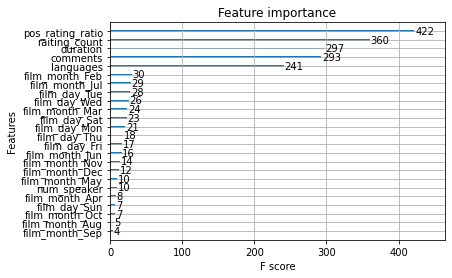

In [ ]:
plot_importance(xgb_grid.best_estimator_)

In [ ]:
predictions_xgb = xgb_grid.predict(X_valid) 
# Calculate MAE
mae_xgb = mean_absolute_error(predictions_xgb, y_valid)

print("Mean Absolute Error:" , mae_xgb)

Mean Absolute Error: 465165.7426747988


In [ ]:
y_mae = [min(maes_dtr), min(maes_rfr), mae_xgb]
x_mae = ['Decision Tree MAE', 'Random Forest MAE', 'XGB MAE']

Text(0, 0.5, 'Mean Absolute Error')

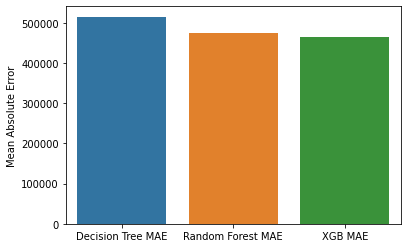

In [ ]:
sns.barplot(x=x_mae, y=y_mae)
plt.ylabel("Mean Absolute Error")


CONCLUSION

The XGB regressor model with hyper paramter tunnig has achieved the lowest mean absolute error of ~460000, which means that its predictions can be of by that much. Considering the the mean median value for TED talk views is about 1.1e+6 it is clear the the models are not perfoming very well on this dataset. More work is needed on feature engineering to produce features with higher importance and with low cardinality from the rest of the cathegorical variables - tags, ratings, speaker occupation. However we can see that the pos_rating_ratio and rating_count features are of the highest importance when making predictions.